In [1]:
#Deep dream

In [2]:
from keras.applications import inception_v3
from keras import backend as K

Using TensorFlow backend.


In [3]:
#PRETRAINED INCEPTION MODEL
K.set_learning_phase(0)
model = inception_v3.InceptionV3(weights = 'imagenet',include_top=False)

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 281s 3us/step


In [4]:
# Setting up the DeepDream configuration
layer_contributions = {
    'mixed2' : 0.2,
    'mixed3' : 3.,
    'mixed4' : 2.,
    'mixed5' : 1.5,
}

In [5]:
#Defining The loss to be maximized
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, :])) / scaling

In [7]:
#Gradient-ascent process
dream = model.input

grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('... Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [11]:
#Auxiliary functions
import numpy as np
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
              float(size[0]) / img.shape[1],
              float(size[1]) / img.shape[2],
              1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname) :
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [12]:
# Running gradient ascent over different successive scales
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10.
base_image_path = 'C:/Users/pongsasit/Desktop/16053_research/data/a.flat 椅子/deepdream.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale **i))
                  for dim in original_shape])
    successive_shapes = successive_shapes[::-1]
    
    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0])
    
    for shape in successive_shapes:
        print('Processing image shape', shape)
        img = resize_img(img, shape)
        img = gradient_ascent(img,
                             iterations = iterations,
                             step = step,
                             max_loss = max_loss)
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        
        img += lost_detail
        shrunk_original_img = resize_img(original_img, shape)
        save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
    save_img(img, fname='final_dream.png')
    

Processing image shape (514, 720)
... Loss value at 0 : 2.66739
... Loss value at 1 : 3.3335998
... Loss value at 2 : 4.109516
... Loss value at 3 : 4.840826
... Loss value at 4 : 5.581643
... Loss value at 5 : 6.3218956
... Loss value at 6 : 7.000835
... Loss value at 7 : 7.688417
... Loss value at 8 : 8.324117
... Loss value at 9 : 8.982085
... Loss value at 10 : 9.583157


C:\Users\pongsasit\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  app.launch_new_instance()


Processing image shape (514, 720)


In [64]:
from keras.preprocessing import image
#import numpy as np
final_dream = 'C:/Users/pongsasit/Desktop/code/deepdream/final_dream.png'
base_image_path = 'C:/Users/pongsasit/Desktop/16053_research/data/a.flat 椅子/deepdream.jpg'

def convert(img_path):
    img = image.load_img(img_path, target_size=(1000,1000))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor

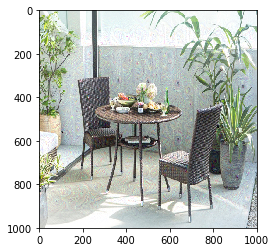

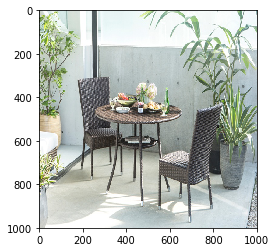

In [65]:
# display the images
import matplotlib.pyplot as plt
# content and style ims side-by-side
plt.imshow(convert(final_dream)[0])
plt.show()
plt.imshow(convert(base_image_path)[0])
plt.show()